In [1]:
import mne
import numpy as np

In [2]:

mne.set_log_level('error')


In [3]:
data_dir = "Processed"
BADS = [['T3'], ['O1'], [], ['F3', 'Cz'], ['F3']]

In [4]:
p_num = 2

raw = mne.io.read_raw_fif(f"{data_dir}/P{p_num}/P{p_num}-raw.fif", preload=True)
raw.set_montage('standard_1020')
for bad in BADS[p_num-1]:
    raw.info['bads'].append(bad)
events = mne.read_events(f"{data_dir}/P{p_num}/P{p_num}_eve.fif")

# Below we will extract GOOD portions of recording. 6 is start of focus block, 7 is end.
segments = []
sfreq = raw.info['sfreq']

# Get all event indices for 6 and 7
event_6_idxs = np.where(events[:, 2] == 6)[0]
event_7_idxs = np.where(events[:, 2] == 7)[0]

# Pair them in order (assumes 6 always comes before 7)
for start_idx in event_6_idxs:
  # Find the next event_7 *after* this event_6
  next_7 = event_7_idxs[event_7_idxs > start_idx]
  if len(next_7) == 0:
    continue  # no matching 7
  end_idx = next_7[0]

  start_sample = events[start_idx, 0]
  end_sample = events[end_idx, 0]

  tmin = start_sample / sfreq
  tmax = end_sample / sfreq

  cropped = raw.copy().crop(tmin=tmin, tmax=tmax)
  segments.append(cropped)

# Concatenate all cropped blocks into one Raw object
raw_blocks = mne.concatenate_raws(segments)

low_cut = 1.0   
hi_cut  = 30
raw_block_filt = raw_blocks.copy().filter(low_cut, hi_cut)

events_ica = mne.make_fixed_length_events(raw_block_filt, duration=1.0)
epochs_ica = mne.Epochs(raw_block_filt, events_ica, tmin=0.0, tmax=1.0,
                        baseline=None, preload=True)
ica = mne.preprocessing.ICA(n_components=0.99, random_state=42)
# Then run ICA on this
ica.fit(epochs_ica)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,18 iterations on epochs (511789 samples)
ICA components,6
Available PCA components,7
Channel types,eeg
ICA components marked for exclusion,—


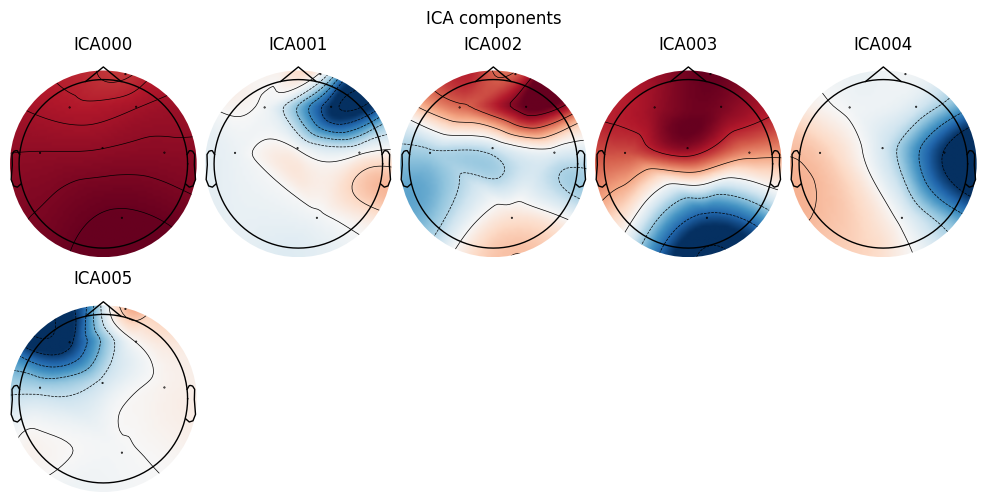

In [5]:
ica.plot_components();

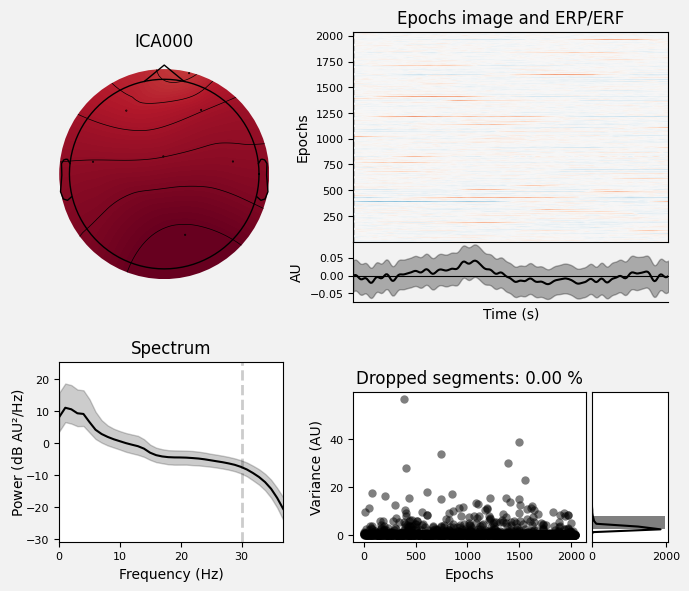

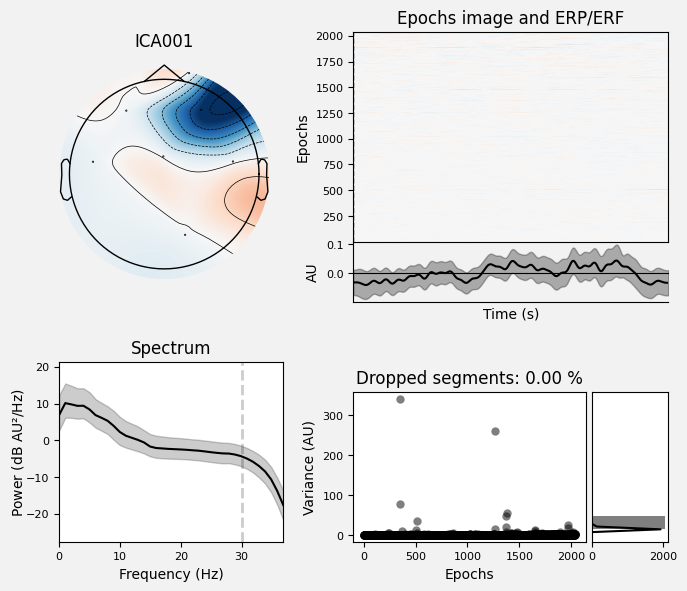

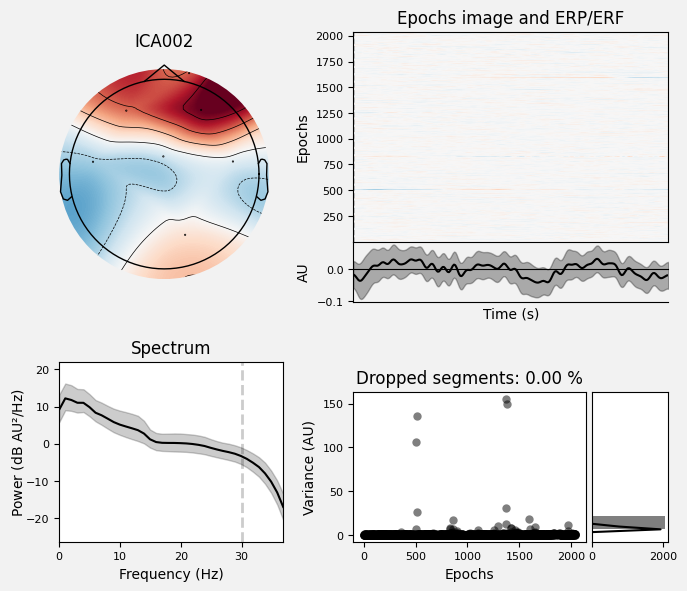

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [6]:
ica.plot_properties(epochs_ica, picks=[0, 1, 2])

In [8]:
ica.exclude = []
num_excl = 0
max_ic = 1
z_thresh = 3.5
z_step = .05

while num_excl < max_ic:
    eog_indices, eog_scores = ica.find_bads_eog(epochs_ica,
                                                ch_name=['Fp2'], 
                                                threshold=z_thresh
                                                )
    num_excl = len(eog_indices)
    z_thresh -= z_step # won't impact things if num_excl is ≥ n_max_eog 

# assign the bad EOG components to the ICA.exclude attribute so they can be removed later
ica.exclude = eog_indices

print(eog_indices)
print('Final z threshold = ' + str(round(z_thresh, 2)))

[0]
Final z threshold = 1.85


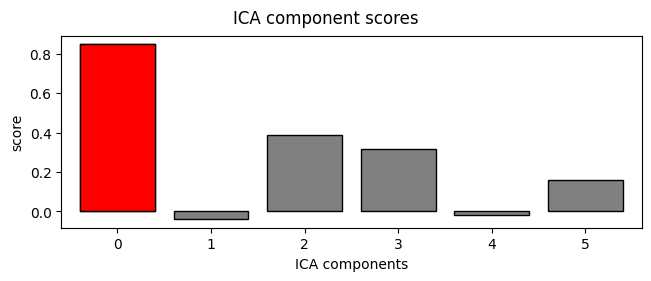

In [9]:
ica.plot_scores(eog_scores);

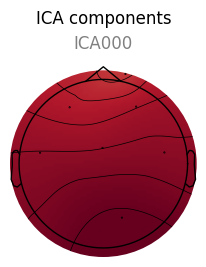

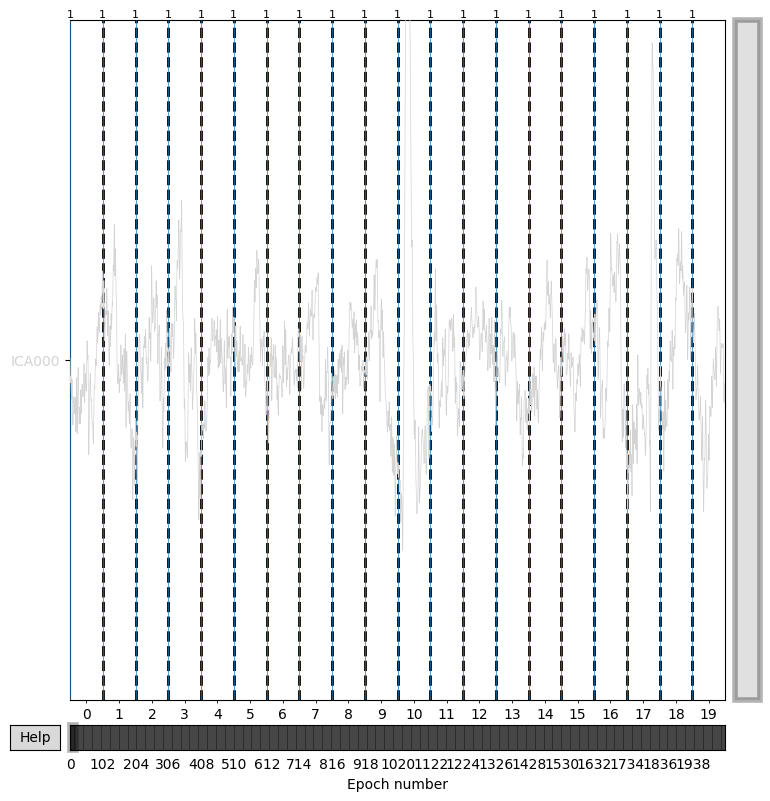

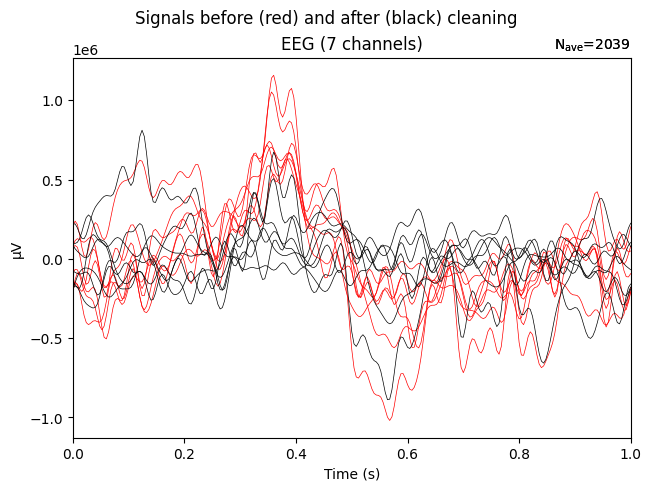

In [10]:
# Plot those components' topographies
ica.plot_components(picks=ica.exclude)

# See their time series contributions
ica.plot_sources(epochs_ica, picks=ica.exclude)

# Check how removing them would affect average evoked
ica.plot_overlay(epochs_ica.average(), exclude=ica.exclude);

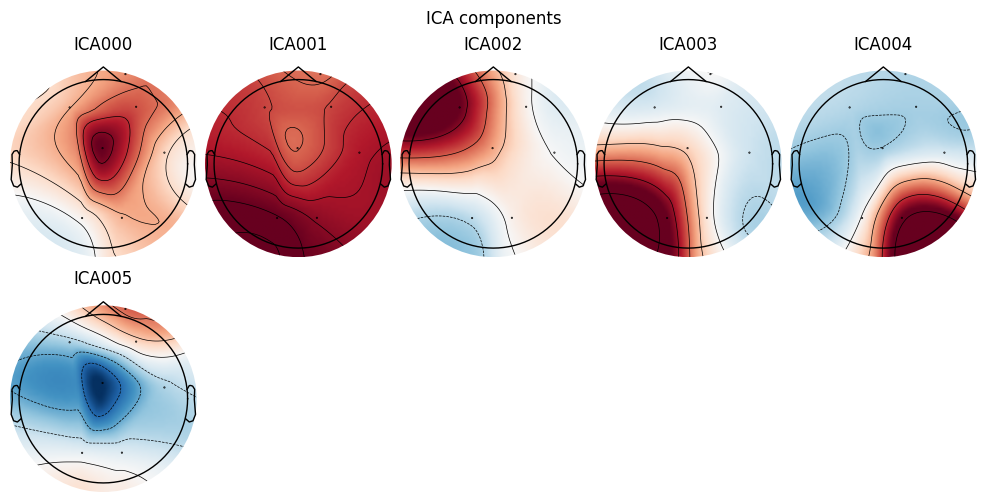

[0]
Final z threshold = 1.6
147.73286666666667
8822


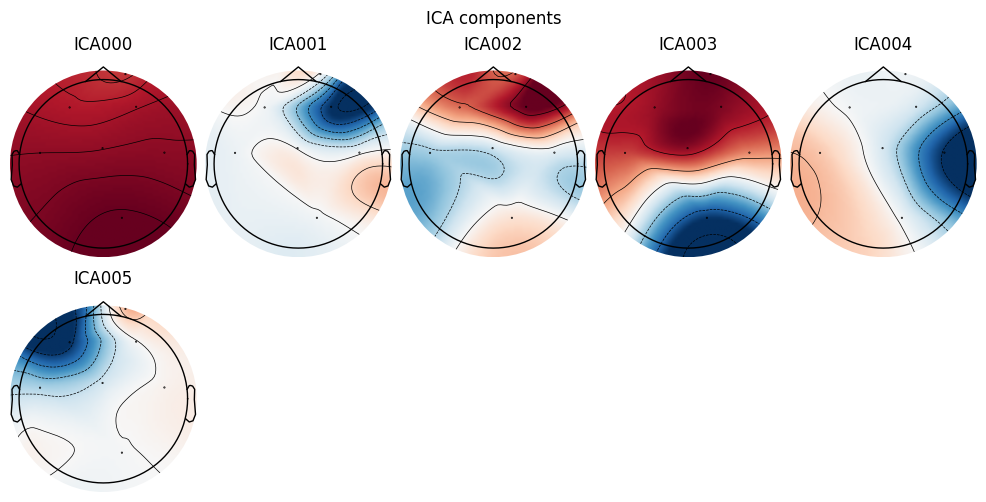

[0]
Final z threshold = 1.85
34.0674
2039


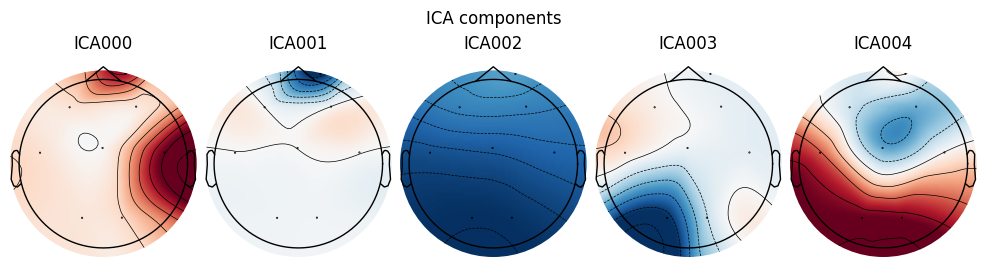

[1, 0]
Final z threshold = 1.55
19.400666666666666
1159


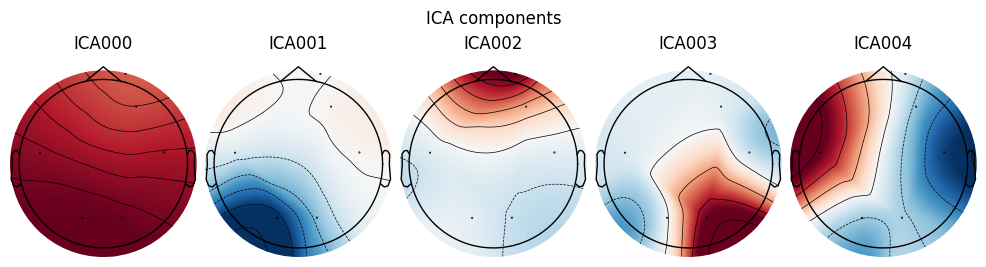

[0, 2]
Final z threshold = 1.6
19.400866666666666
1159


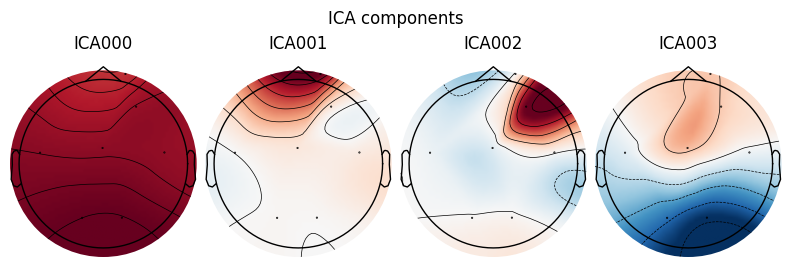

[1]
Final z threshold = 1.5
19.400733333333335
1159


In [39]:

# Need event codes
for p_num in range(1, 6): 
    raw = mne.io.read_raw_fif(f"{data_dir}/P{p_num}/P{p_num}-raw.fif", preload=True)
    for bad in BADS[p_num-1]:
      raw.info['bads'].append(bad)
    
    events = mne.read_events(f"{data_dir}/P{p_num}/P{p_num}_eve.fif")
    
    # Below we will extract GOOD portions of recording. 6 is start of focus block, 7 is end.
    segments = []
    sfreq = raw.info['sfreq']
    
    # Get all event indices for 6 and 7
    event_6_idxs = np.where(events[:, 2] == 6)[0]
    event_7_idxs = np.where(events[:, 2] == 7)[0]
    
    # Pair them in order (assumes 6 always comes before 7)
    for start_idx in event_6_idxs:
      # Find the next event_7 *after* this event_6
      next_7 = event_7_idxs[event_7_idxs > start_idx]
      if len(next_7) == 0:
        continue  # no matching 7
      end_idx = next_7[0]
    
      start_sample = events[start_idx, 0]
      end_sample = events[end_idx, 0]
    
      tmin = start_sample / sfreq
      tmax = end_sample / sfreq
    
      cropped = raw.copy().crop(tmin=tmin, tmax=tmax)
      segments.append(cropped)
    
    # Concatenate all cropped blocks into one Raw object
    raw_blocks = mne.concatenate_raws(segments)
    
    low_cut = 1.0   
    hi_cut  = 40
    raw_block_filt = raw_blocks.copy().filter(low_cut, hi_cut)
    
    events_ica = mne.make_fixed_length_events(raw_block_filt, duration=1.0)
    epochs_ica = mne.Epochs(raw_block_filt, events_ica, tmin=0.0, tmax=1.0,
                            baseline=None, preload=True)

    ica = mne.preprocessing.ICA(n_components=0.99, random_state=42)
    # Then run ICA on this
    ica.fit(epochs_ica)

    ica.plot_components()
    ica.exclude = []
    num_excl = 0
    max_ic = 1
    z_thresh = 3.5
    z_step = .05
    
    while num_excl < max_ic:
        eog_indices, eog_scores = ica.find_bads_eog(epochs_ica,
                                                    ch_name=['Fp2'], 
                                                    threshold=z_thresh
                                                    )
        num_excl = len(eog_indices)
        z_thresh -= z_step # won't impact things if num_excl is ≥ n_max_eog 
    
    # assign the bad EOG components to the ICA.exclude attribute so they can be removed later
    ica.exclude = eog_indices
    
    print(eog_indices)
    print('Final z threshold = ' + str(round(z_thresh, 2)))
    
    # ica.plot_scores(eog_scores);
    ica.save(f"{data_dir}-Better/P{p_num}/P{p_num}-ica.fif", overwrite=True)
    